
# Assignment 4

## Text Classification Using TF-IDF and Logistic Regression


In [82]:
# Import all necessary libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import re
import string
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report

from sklearn.metrics import confusion_matrix

In [3]:
# load the data and learn insights about it
newsgroups = fetch_20newsgroups(subset='all')

print("Number of articles: " + str(len(newsgroups.data)))
print("Number of diffrent categories: " + str(len(newsgroups.target_names)))

newsgroups.target_names


Number of articles: 18846
Number of diffrent categories: 20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
#sample data 
print(newsgroups.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




Each document is a text written in English in a form of an email with a lot of punctuations. You should always do some pre-processing but here we’ll just concentrate on the model.

In [5]:
# print sample data
print("\n".join(newsgroups.data[1121].split("\n")[:]))

From: et@teal.csn.org (Eric H. Taylor)
Subject: Re: Gravity waves, was: Predicting gravity wave quantization & Cosmic Noise
Summary: Dong ....  Dong ....  Do I hear the death-knell of relativity?
Keywords: space, curvature, nothing, tesla
Nntp-Posting-Host: teal.csn.org
Organization: 4-L Laboratories
Distribution: World
Expires: Wed, 28 Apr 1993 06:00:00 GMT
Lines: 30

In article <C4KvJF.4qo@well.sf.ca.us> metares@well.sf.ca.us (Tom Van Flandern) writes:
>crb7q@kelvin.seas.Virginia.EDU (Cameron Randale Bass) writes:
>> Bruce.Scott@launchpad.unc.edu (Bruce Scott) writes:
>>> "Existence" is undefined unless it is synonymous with "observable" in
>>> physics.
>> [crb] Dong ....  Dong ....  Dong ....  Do I hear the death-knell of
>> string theory?
>
>     I agree.  You can add "dark matter" and quarks and a lot of other
>unobservable, purely theoretical constructs in physics to that list,
>including the omni-present "black holes."
>
>     Will Bruce argue that their existence can be inferre

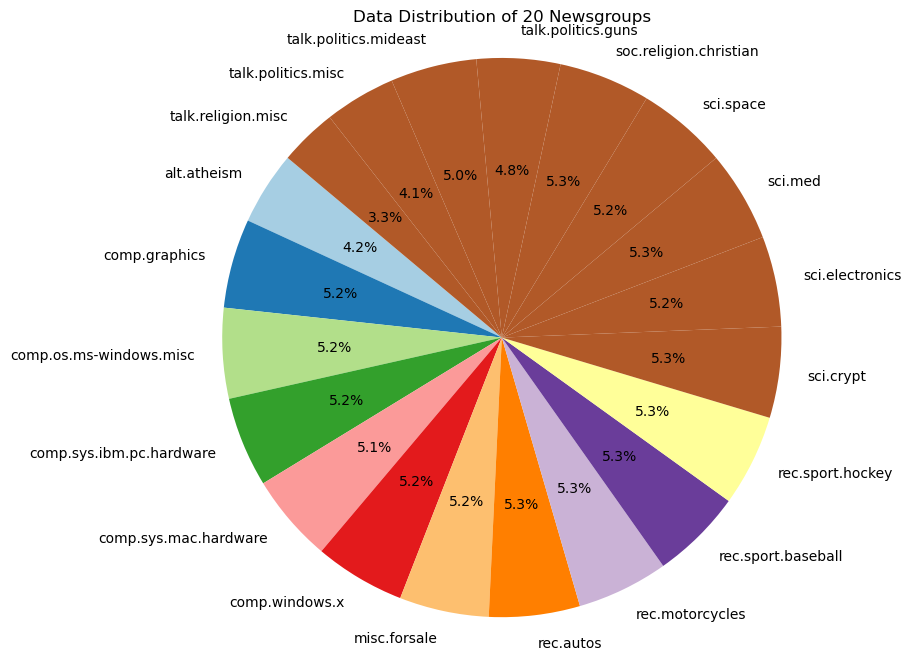

In [6]:
# Count the number of documents in each category
category_counts = dict(zip(newsgroups.target_names, [0] * len(newsgroups.target_names)))
for target in newsgroups.target:
    category_counts[newsgroups.target_names[target]] += 1

# Data to plot
labels = list(category_counts.keys())
sizes = list(category_counts.values())
colors = plt.cm.Paired(range(len(labels)))

# Plot
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Distribution of 20 Newsgroups')
plt.show()

## Load TRAINING Set

In [7]:
#Loading the training data.
mydata_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers', 'quotes'))
print('Training data size:', len(mydata_train['data']))

Training data size: 11314


## Load TEST set

In [8]:
#Loading the test data.
mydata_test = fetch_20newsgroups(subset='test', shuffle=True, remove = ('headers', 'footers', 'quotes'))
print('Test data size:', len(mydata_test['data']))

Test data size: 7532


## Data Preparation

In [ ]:
#preparing training data
mydata_train_df = pd.DataFrame({'data': mydata_train.data, 'target': mydata_train.target})
mydata_train_df.head()


# Preparing test data 
mydata_test_df = pd.DataFrame({'data': mydata_test.data, 'target': mydata_test.target})
mydata_test_df.head()

### Basic Preprocessing
- remove Na records
- remove punctuation 
- convert all to lowercase 
- remove stopwords 
- tokenisation 

In [24]:
# 1) cleaning Training Data 
mydata_train_df=mydata_train_df.dropna() #drop na records


# 2) Punctuation
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z\s]', '', text).replace('\n', '')  # Remove non-letter characters and newline


mydata_train_df['preproc'] = mydata_train_df['data'].apply(remove_punctuation)

# 3) Remove uppercase
mydata_train_df['preproc'] = mydata_train_df['preproc'].str.lower()


# 4) remove stopwords 
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split() # split the text into individual words
    filtered_words = []

    # loop through each word in the list of words
    for word in words:

        if word not in stop_words:
            filtered_words.append(word)

    cleaned_text = ' '.join(filtered_words)
    return cleaned_text


mydata_train_df['preproc'] = mydata_train_df['preproc'].apply(remove_stopwords)


mydata_train_df['tokens'] = mydata_train_df['preproc'].apply(word_tokenize) #tokenization

mydata_train_df.head()

,data,target,preproc,tokens
0,I was wondering if anyone out there could enli...,7,wondering anyone could enlighten car sawthe da...,"[wondering, anyone, could, enlighten, car, saw..."
1,A fair number of brave souls who upgraded thei...,4,fair number brave souls upgraded si clock osci...,"[fair, number, brave, souls, upgraded, si, clo..."
2,"well folks, my mac plus finally gave up the gh...",4,well folks mac plus finally gave ghost weekend...,"[well, folks, mac, plus, finally, gave, ghost,..."
3,\nDo you have Weitek's address/phone number? ...,1,weiteks addressphone number id like get inform...,"[weiteks, addressphone, number, id, like, get,..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,article cowcbnpworldstdcom tombakerworldstdcom...,"[article, cowcbnpworldstdcom, tombakerworldstd..."


In [25]:
#clean test data 
mydata_test_df=mydata_test_df.dropna() #drop na records
mydata_test_df['preproc'] = mydata_test_df['data'].apply(remove_punctuation)
mydata_test_df['preproc'] = mydata_test_df['preproc'].str.lower()
mydata_test_df['preproc'] = mydata_test_df['preproc'].apply(remove_stopwords) #stopwords
mydata_test_df['tokens'] = mydata_test_df['preproc'].apply(word_tokenize) #tokenization
mydata_test_df.head()

,data,target,preproc,tokens
0,I am a little confused on all of the models of...,7,little confused models bonnevillesi heard le s...,"[little, confused, models, bonnevillesi, heard..."
1,I'm not familiar at all with the format of the...,5,im familiar format xface thingies butafter see...,"[im, familiar, format, xface, thingies, butaft..."
2,"\nIn a word, yes.\n",0,word yes,"[word, yes]"
3,\nThey were attacking the Iraqis to drive them...,17,attacking iraqis drive kuwaita country whose c...,"[attacking, iraqis, drive, kuwaita, country, w..."
4,\nI've just spent two solid months arguing tha...,19,ive spent two solid months arguing thing anobj...,"[ive, spent, two, solid, months, arguing, thin..."


## TF-IDF Vectorization
Implement TF-IDF here. You can use sklearn.

In [26]:
# Scikit's TfidfVectorizer : tfidf for train data then test data 

train_corpus = mydata_train_df['tokens']
test_corpus = mydata_test_df['tokens']

In [28]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)

x_train = vectorizer.fit_transform(train_corpus)
x_test = vectorizer.transform(test_corpus)


# Get the shape and vocabulary size
print("Train TF-IDF shape:", x_train.shape)
print("Test TF-IDF shape:", x_test.shape)
print("vocabulary:", x_train.shape[1])  # 151590 is the no. of unique words in train data

Train TF-IDF shape: (11314, 151590)
Test TF-IDF shape: (7532, 151590)
vocabulary: 151590


In [29]:
# Extracting target variables
y_train = mydata_train_df['target']  # Training target variable
y_test = mydata_test_df['target'] 

## Logistic Regression Classifier
Implement LR classifier here. You can use sklearn.

In [69]:


model = LogisticRegression(max_iter=1000,penalty='l2', solver='liblinear', C=100)

model.fit(x_train, y_train)
y_pred=model.predict(x_test)

In [76]:
accuracy = model.score(x_test, y_test)
print(f"Accuracy is: {accuracy:.2f}")


# precision : how often a machine learning model correctly predicts the positive class. 
precision = precision_score(y_test, y_pred, average='macro') 
print(f"Precision is: {precision:.2f}")


#recall : True Positives / (True Positives + False Negatives)
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall is: {recall:.2f}")


# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro') 
print(f"F1 Score is: {f1:.2f}")

Accuracy is: 0.66
Precision is: 0.66
Recall is: 0.65
F1 Score is: 0.65


### Confusion Matrix


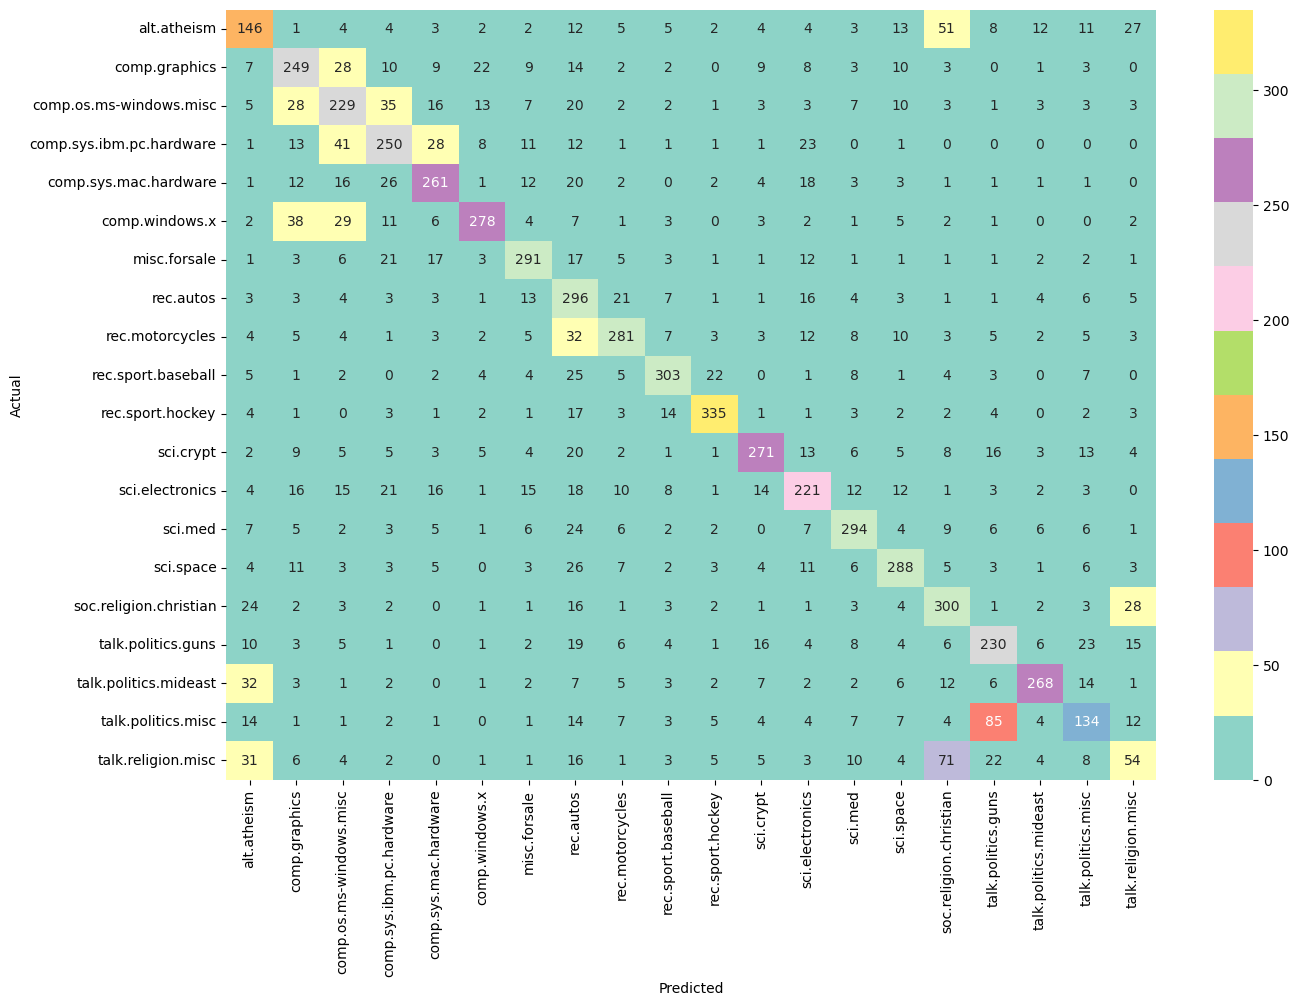

In [84]:
# calculate confusion matrix using built-in functionality in sklearn
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))

# remember labels = list(category_counts.keys())
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [45]:
# #Hyperparameter tuning -- for self ( was seeing the best parameters for my logistic model )


# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameter grid
# param_grid = {
#     'C': [1, 10, 100],  # Inverse of regularization strength
#     'penalty': ['l2'],        # Regularization type
#     'solver': ['liblinear'] # Solvers that support L1 penalty
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
#                            scoring='accuracy', cv=5, n_jobs=-1)

# grid_search.fit(x_train, y_train)

# # Get the best hyperparameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Hyperparameters:", best_params)
# print("Best Cross-Validation Score:", best_score)
